> credits: originally by Gael Varoquaux
> 
> adapted by: Chris Holdgraf

In [1]:
import numpy as np
from nilearn.input_data import MultiNiftiMasker
from nilearn.datasets import fetch_miyawaki2008
import pylab as plt
import os.path as op
from tqdm import tqdm
path_data = op.expanduser('~/data_ucsf/machine_learning')
%matplotlib inline


# About this tutorial
This example is also drawn from the `nilearn` docs. You can find the original [here](https://nilearn.github.io/auto_examples/02_decoding/plot_miyawaki_encoding.html#sphx-glr-auto-examples-02-decoding-plot-miyawaki-encoding-py).

This example partly reproduces the encoding model presented in
> [Visual image reconstruction from human brain activity
    using a combination of multiscale local image decoders](http://www.cell.com/neuron/abstract/S0896-6273%2808%2900958-6),
    Miyawaki, Y., Uchida, H., Yamashita, O., Sato, M. A.,
    Morito, Y., Tanabe, H. C., ... & Kamitani, Y. (2008).
    Neuron, 60(5), 915-929.


# Encoding models for visual stimuli
## Encoding vs. Decoding.
Thus far we have focused on using predictive models for decoding. That is - predicting states of the world using brain activity. However, it is possible to do the reverse: predict brain activity using information about the world. These are known as *encoding* models.

In perceptual neurosceince, encoding models try to predict neuronal activity using information from presented stimuli, like an image or sound. 

* Decoding: brain -> model -> world prediction
* Encoding: world -> model -> brain prediction

It is possible to fit encoding models using `nilearn` and `scikit-learn`. Here we'll use an encoding model to predict **fMRI data** from **visual stimuli**, using the dataset from
[Miyawaki et al., 2008](http://www.cell.com/neuron/abstract/S0896-6273%2808%2900958-6>).

## The Miyawaki dataset
Participants were shown images, which consisted of random 10x10 binary
(either black or white) pixels, and the corresponding fMRI activity was
recorded. We will try to predict the activity in each voxel
from the binary pixel-values of the presented images. Then we extract the
receptive fields for a set of voxels to see which pixel location a voxel
is most sensitive to.

# Preparing the data
## Loading the data

We'll load the data using the same kind of `nilearn` functions that we've used before:

In [2]:
dataset = fetch_miyawaki2008(data_dir=path_data)
print(dataset['description'])

Miyawaki 2008


Notes
-----
Collection of result images from MVPA investigation of the human visual systems.

This fMRI study reconstructed visual images by combining local
image bases of multiple scales. Their contrasts were independently
decoded from fMRI activity by selecting important voxels and
capitalizing on their correlation structure.

Content
-------
    :'label': Paths to text files containing session and target data
    :'func': Paths to nifti files with BOLD data
    :'mask': Path to general mask nifti that defines target volume in visual cortex
    :'mask_roi': List of paths to images with specific data ('RH' for right hemisphere, 'LH' for left hemisphere, 'Vxxx' denote visual areas)


References
----------
For more information on this dataset's structure, see
http://www.cns.atr.jp/dni/en/downloads/ fmri-data-set-for-visual-image-reconstruction

Miyawaki, Y., Uchida, H., Yamashita, O., Sato, M. A.,
Morito, Y., Tanabe, H. C., ... & Kamitani, Y. (2008).
Neuron, 60(5), 915-9

This dataset is broken up into both training and testing data. Here we'll only use the training data of this study, where random binary images were shown.

In [3]:
# training data starts after the first 12 files
fmri_random_runs_filenames = dataset.func[12:]
stimuli_random_runs_filenames = dataset.label[12:]

## Working with multiple data files

The `nilearn.input_data.MultiNiftiMasker` class allows us to mask multiple Nifti files at once. We'll use this to load the fMRI data, clean and mask it.

In [4]:
# This is a list of filenames, corresponding to multiple runs of the experiment
fmri_random_runs_filenames[:5]

['/Users/choldgraf/data_ucsf/machine_learning/miyawaki2008/func/data_random_run01.nii.gz',
 '/Users/choldgraf/data_ucsf/machine_learning/miyawaki2008/func/data_random_run02.nii.gz',
 '/Users/choldgraf/data_ucsf/machine_learning/miyawaki2008/func/data_random_run03.nii.gz',
 '/Users/choldgraf/data_ucsf/machine_learning/miyawaki2008/func/data_random_run04.nii.gz',
 '/Users/choldgraf/data_ucsf/machine_learning/miyawaki2008/func/data_random_run05.nii.gz']

In [5]:
# This will mask and clean each dataset
# It outputs a list of vectorized arrays
masker = MultiNiftiMasker(mask_img=dataset.mask, detrend=True,
                          standardize=True)
masker.fit()
fmri_data = masker.transform(fmri_random_runs_filenames)

In [6]:
print(type(fmri_data))
fmri_data[0]

<class 'list'>


array([[-0.84576047, -2.00409847, -0.63856833, ..., -0.0703331 ,
         2.00162479,  0.13446872],
       [-0.86547237, -1.7537534 , -1.17549528, ...,  0.94502133,
        -0.81782921, -0.57213769],
       [-0.39525228, -0.13824568, -0.56777185, ...,  0.97448285,
         0.69280806, -0.91134732],
       ..., 
       [-1.06923005, -0.05674129, -0.05552219, ..., -0.1757492 ,
        -1.06307467, -0.27648925],
       [ 0.67326913,  2.0415803 , -0.33138947, ...,  0.81178806,
        -0.08484034, -0.06203715],
       [ 1.74079517,  1.86753125,  1.93358524, ...,  0.03240438,
         1.31066568, -2.28357008]])

## Reading in stimuli

These files define the stimuli that are used in this dataset

In [7]:
stimuli_random_runs_filenames[:5]

['/Users/choldgraf/data_ucsf/machine_learning/miyawaki2008/label/data_random_run01_label.csv',
 '/Users/choldgraf/data_ucsf/machine_learning/miyawaki2008/label/data_random_run02_label.csv',
 '/Users/choldgraf/data_ucsf/machine_learning/miyawaki2008/label/data_random_run03_label.csv',
 '/Users/choldgraf/data_ucsf/machine_learning/miyawaki2008/label/data_random_run04_label.csv',
 '/Users/choldgraf/data_ucsf/machine_learning/miyawaki2008/label/data_random_run05_label.csv']

Since it's a CSV, we'll again use pandas to load it. Each CSV is one run. Within each CSV, each row is one stimulus presentation, consisting of a 10x10 grid of black and white squares:

In [8]:
import pandas as pd
stimulus = pd.read_csv(stimuli_random_runs_filenames[0])
stimulus.shape

(144, 100)

In [9]:
# shape of the binary (i.e. black and wihte values) image in pixels
stimulus_shape = (10, 10)

# We load the visual stimuli from csv files
stimuli = []
for stimulus_run in stimuli_random_runs_filenames:
    stimulus = pd.read_csv(stimulus_run, header=None).values.astype(int)
    
    # Reshape so it's 10 x 10
    stimulus = stimulus.reshape((-1,) + stimulus_shape, order='F')
    stimuli.append(stimulus)

Let's take a look at some of these binary images:



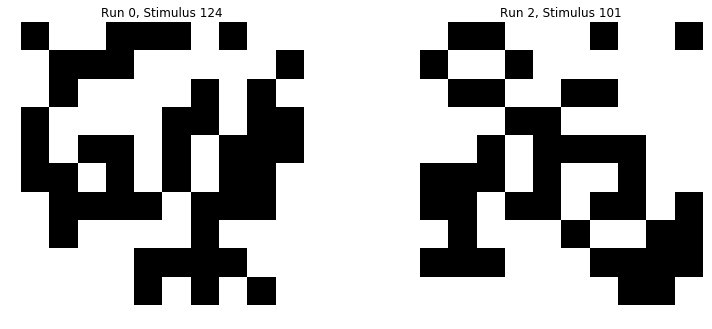

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for (run, stimulus), ax in zip([(0, 124), (2, 101)], axs):
    ax.imshow(stimuli[run][stimulus], interpolation='nearest', cmap='gray')
    ax.set_title('Run {}, Stimulus {}'.format(run, stimulus))
    ax.set_axis_off()
plt.tight_layout(w_pad=10)

## Reshaping data for the model
We now stack the fmri and stimulus data and remove an offset in the
beginning/end. This will prep the data for our model fitting

In [11]:
fmri_data = np.vstack([fmri_run[2:] for fmri_run in fmri_data])
stimuli = np.vstack([stimuli_run[:-2] for stimuli_run in stimuli]).astype(float)

fmri_data is a matrix of *samples* x *voxels*



In [12]:
print(fmri_data.shape)

(2860, 5438)


We flatten the last two dimensions of stimuli
so it is a matrix of *samples* x *pixels*.



In [13]:
# Flatten the stimuli
stimuli = np.reshape(stimuli, (-1, stimulus_shape[0] * stimulus_shape[1]))

print(stimuli.shape)

(2860, 100)


# Building the encoding models

In the last tutorail we built a classifier using brain activity and labels for different stimuli that were presented. In this case, we wish to make a different kind of prediction: a *continuous* representation of the each voxel using the pixel data from the stimuli.

These types of models are called **voxel-wise encoding models**, and they use *regression* to predict continuous outputs from data. Specifically, we'll use [Ridge regression](http://en.wikipedia.org/wiki/Tikhonov_regularization).
For each voxel we fit an independent regression model,
using the pixel-values of the visual stimuli to predict the neuronal
activity in this voxel.

In [14]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from tqdm import tqdm

## Cross-validating our encoding model
Using 10-fold cross-validation, we partition the data into 10 'folds'.
We hold out each fold of the data for testing, then fit a ridge regression
to the remaining 9/10 of the data.

As this is an encoding model, we'll use stimuli as predictors
and fmri_data as targets, and create predictions for the held-out 10th set.

In addition, we'll **score the model** using the coefficient of determination ($R^2$). This estimates the model's ability to explain variance in the neural activity.

In [15]:
from sklearn.metrics import r2_score

estimator = Ridge(alpha=100.)
cv = KFold(n_splits=10)

scores = []
for train, test in tqdm(list(cv.split(fmri_data))):
    # we train the Ridge estimator on the training set
    X = stimuli.reshape(-1, 100)
    X_train = X[train]
    X_test = X[test]
    y_train = fmri_data[train]
    y_test = fmri_data[test]

    # and predict the fMRI activity for the test set
    model = Ridge(alpha=100.).fit(X_train, y_train)
    predictions = model.predict(X_test)

    # we compute how much variance our encoding model explains in each voxel
    scores.append(r2_score(y_test, predictions, multioutput='raw_values'))

100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


## Mapping the encoding scores on the brain

We've fit an encoding model for each voxel of the brain. Now we can inspect the model's performance at each location.

To plot the scores onto the brain, we create a Nifti1Image using
the scores output by our model. We'll again use the `NiftiMasker` to convert it back to volume space.

In [16]:
cut_score = np.mean(scores, axis=0)
cut_score[cut_score < 0] = 0

# bring the scores into the shape of the background brain
score_map_img = masker.inverse_transform(cut_score)

/Users/choldgraf/Dropbox/github/forks/python/matplotlib/lib/matplotlib/artist.py:880: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  return func(v)


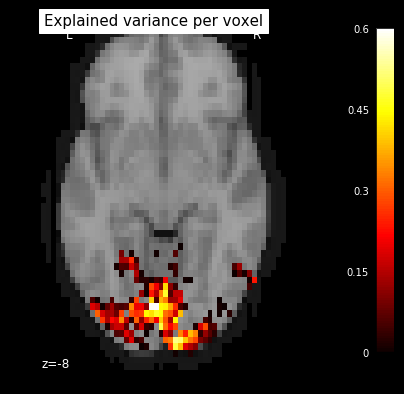

In [17]:
from nilearn.plotting import plot_stat_map
display = plot_stat_map(score_map_img, bg_img=dataset.background,
                        cut_coords=[-8], display_mode='z', aspect=1.25,
                        title='Explained variance per voxel')
plt.gcf().set_size_inches(5, 5)

## Thresholding our scores and making a final plot
We may also want to threshold our scores so that only "valid" scores are plotted. We'll do this thresholding below

In [18]:
from nilearn.image import threshold_img
thresholded_score_map_img = threshold_img(score_map_img, threshold=.2)

Now we'll highlight a few voxels of particular interest. We'll inspect these more closely later on.

/Users/choldgraf/Dropbox/github/forks/python/matplotlib/lib/matplotlib/artist.py:880: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  return func(v)


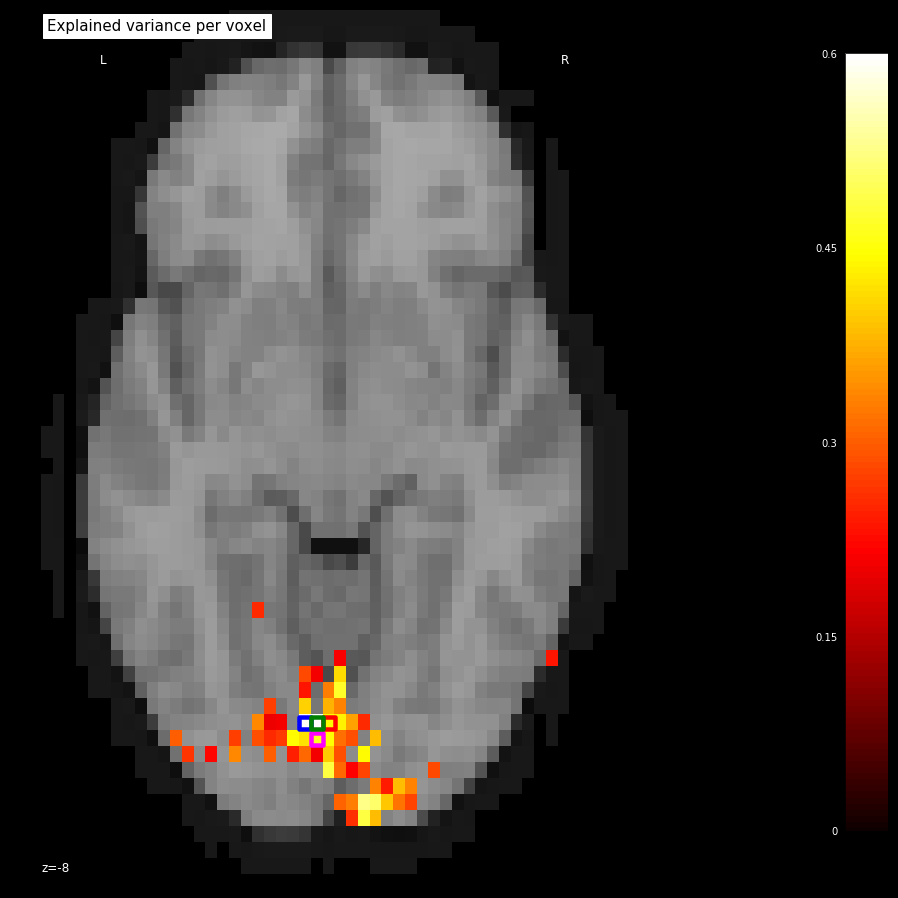

In [19]:
from nilearn.image.resampling import coord_transform

def index_to_xy_coord(x, y, z=10):
    '''Transforms data index to coordinates of the background + offset'''
    coords = coord_transform(x, y, z,
                             affine=thresholded_score_map_img.affine)
    return np.array(coords)[np.newaxis, :] + np.array([0, 1, 0])


xy_indices_of_special_voxels = [(30, 10), (32, 10), (31, 9), (31, 10)]

display = plot_stat_map(thresholded_score_map_img, bg_img=dataset.background,
                        cut_coords=[-8], display_mode='z', aspect=1.25,
                        title='Explained variance per voxel')

# creating a marker for each voxel and adding it to the statistical map

for i, (x, y) in enumerate(xy_indices_of_special_voxels):
    display.add_markers(index_to_xy_coord(x, y), marker_color='none',
                        edgecolor=['b', 'r', 'magenta', 'g'][i],
                        marker_size=140, marker='s',
                        facecolor='none', lw=4.5)


# re-set figure size after construction so colorbar gets rescaled too
fig = plt.gcf()
fig.set_size_inches(12, 12)

# Estimating receptive fields

Now that we can see the distribution of scores across the voxels of interest, let's take a closer look at the receptive fields for the four marked voxels. *It only makes sense to do this for voxels with a relatively high prediction score*.

A voxel's [receptive field](http://en.wikipedia.org/wiki/Receptive_field)
is the region of a stimulus (like an image) where the presence of an object (like a white instead of a black pixel), results in a change in activity
in the voxel.

In our case the receptive field is just the vector of 100
regression  coefficients (one for each pixel) reshaped into the 10x10
form of the original images.

The kind of model we choose to fit will affect the kind of coefficients we will uncover. For example, *Ridge regression* will tend to find a set of coefficients that are relatively normally distributed around 0. [*Lasso regression*](http://en.wikipedia.org/wiki/Lasso_(statistics)) will find a "sparse" solution such that only a few coefficients will be non-zero. You can play around with the effects of each below.

**In practice, you should choose the model that best fits your knowledge of the underlying relationship between brain / stimuli.**

In [22]:
from sklearn.linear_model import LassoLarsCV, RidgeCV
from matplotlib import gridspec
from matplotlib.patches import Rectangle

# automatically estimate the sparsity by cross-validation
lasso = LassoLarsCV(max_iter=10)
# Or find a smooth set of coefficients
ridge = RidgeCV(alphas=np.logspace(-2, 2, 10))

# This is the model we'll actually use
model = lasso

# These are the indices for voxels for which we'll estimate a receptive field.
voxels_to_fit = [1780, 1951, 2131, 1935]

# This is a pixel we'll highlight in each model's receptive field.
marked_pixel = (4, 2)

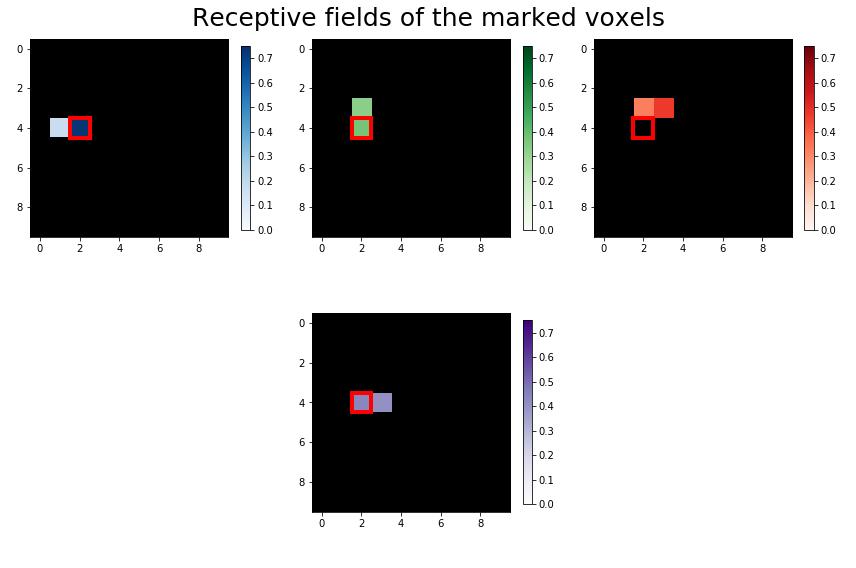

In [23]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs_to_plt = [0, 1, 2, 4]

# we fit the Lasso for each of the three voxels of the upper row
for i, index in enumerate(voxels_to_fit):
    # --- Fit the model ---
    y = fmri_data[:, index]
    model.fit(stimuli, y)

    # we reshape the coefficients into the form of the original images
    rf = model.coef_.reshape((10, 10))

    # --- Visualize the RF ---
    # add a black background
    ax = axs.ravel()[axs_to_plt[i]]
    ax.imshow(np.zeros_like(rf), vmin=0., vmax=1., cmap='gray')
    ax_im = ax.imshow(np.ma.masked_less(rf, 0.1), interpolation="nearest",
                      cmap=['Blues', 'Greens', 'Reds', 'Purples'][i], vmin=0., vmax=0.75)
    # add the marked pixel
    ax.add_patch(Rectangle(
        (marked_pixel[1] - .5, marked_pixel[0] - .5), 1, 1,
        facecolor='none', edgecolor='r', lw=4))
    plt.colorbar(ax_im, ax=ax, shrink=.7)

for ax in axs.ravel()[[3, 5]]:
    ax.set_axis_off()
fig.suptitle('Receptive fields of the marked voxels', fontsize=25)
plt.tight_layout()


Note that these plots are organized according to each voxel's position relative to one another. Given this we can note two things:

1. The receptive fields of the four voxels are close to each other
2. The relative location of the "preferred" pixel in each RF roughly follows the voxels' position relative to one another.

In this way, we've mapped out how the receptive field changes as you move across voxels in the brain. Taken as a whole, we have an idea for how spatial / visual informatino is represented in the brain, and how this representation changes as we move throughout regions of the brain.

# Recap
In this section, we've covered how we can use `sklearn` and `nilearn` in order to use information in the world to model brain activity. This is another exciting approach towards asking questions about the brain, and it only scratches the surface of what you can do with these models.

